# 20.1 因果图

2024/4/23 姚葳、沈华傲、杨瑞维

分工情况：各自完成代码，一起讨论解决遇到的问题

会计研究人员长期以来一直在努力使用工具变量来解决内生性问题，但是关于工具变量的错误推理在会计研究中很常见。
Gow et al. (2016)认为评估工具变量需要进行谨慎的理论因果推理，而不是统计推理。因果图为凸显有效工具变量的要求提供了一个有用的框架。如下因果图可以被视为工具变量的“典型”因果图。

Z的三个关键特征：

+ Z是随机的，没有任何箭头指向Z。

+ Z对X有因果效应，有由Z指向X的箭头。

+ Z对除X以外的任何变量都没有直接的因果效应，即“only through”准则：Z对Y的影响（如果有的话）“只能通过”X来实现。

需要强调的是，即使Z仅通过对X的影响而对Y产生影响，还需要论证工具变量Z的变化是随机的。例如，如果Z是与Y相关的变量W的函数，即使“only through”准则得到满足，X对Y的工具变量估计通常也会存在偏误。
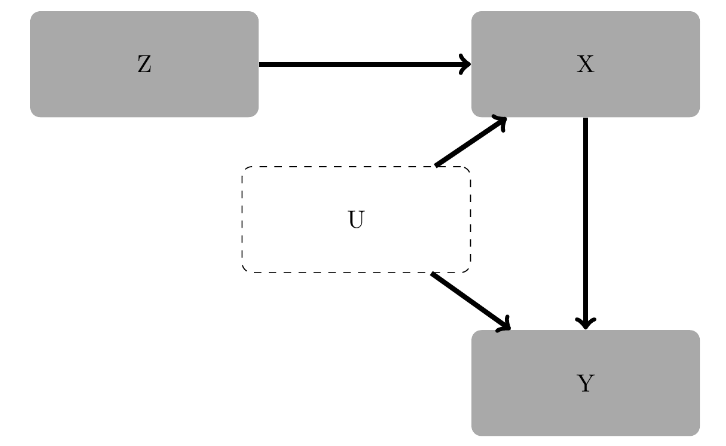

# 20.4 工具变量的有效性

许多研究选择使用统计检验来测试工具变量的有效性，但这种工具变量的检验在实践中的价值很小。

在本节中，我们将研究如果放宽对工具变量随机性的要求，只依靠统计检验来检验工具变量的有效性，可能会取得怎样的结果。

假设 $y = X \beta + \epsilon$，且 $\rho(X, \epsilon) = 0.2$，$\beta = 0$ 。这意味着实际上X和y之间没有因果关系，但存在内生性问题。

In [201]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import linearmodels.iv as iv
from linearmodels.iv.results import compare as iv_compare
from linearmodels.iv.results import IVResults
from scipy.stats import norm, uniform
from scipy.stats import t
from linearmodels.panel import PanelOLS
import warnings
import sqlite3
import matplotlib.pyplot as plt
import re

In [3]:
# 生成模拟数据的参数
n = 1000
beta = 0
corr = 0.2
Sigma = np.array([[1, corr], [corr, 1]])

# 用于生成工具变量
sd_eta = 0.3

# 用于评估工具变量
p_cutoff = 0.05
F_threshold = 30

# 模拟次数（稍后使用）
k = 1000

下面创建一个名为generate_data()的函数来生成具有上述属性和参数值的数据，然后运行它来生成df。在这里，X和 $\epsilon$，它们是均值为0，方差为1的双变量正态分布。

In [4]:
def generate_data():
    X_e = np.random.multivariate_normal([0, 0], Sigma, n)
    X_e_df = pd.DataFrame(X_e, columns=["X", "e"])
    X_e_df["y"] = X_e_df["X"] * beta + X_e_df["e"]
    return X_e_df

np.random.seed(2019)
df = generate_data()

使用这些数据进行OLS回归估计将存在偏差，因此将无法支持可靠的因果推论，但可以创建3个工具变量：$z_1 = x + \eta_1$,$z_2 = \eta_2$,$z_3 = \eta_3$，其中，$\sigma_{\eta_1} = \sigma_{\eta_2} = \sigma_{\eta_3} \sim N(0, 0.09)$，并且独立。



In [5]:
def generate_ivs(df, sd_eta=0.3):
    n = len(df)
    df["z_1"] = df["X"] + np.random.normal(0, sd_eta, n)
    df["z_2"] = np.random.normal(0, sd_eta, n)
    df["z_3"] = np.random.normal(0, sd_eta, n)
    return df

df_ivs = generate_ivs(df)

df_ivs.head()

,X,e,y,z_1,z_2,z_3
0,-0.350921,0.688147,0.688147,0.329442,-0.213869,-0.074299
1,-1.989738,-0.305048,-0.305048,-1.930647,-0.147033,-0.351326
2,-0.153317,0.713917,0.713917,-0.623851,-0.360378,-0.046006
3,-0.626409,-0.262459,-0.262459,-0.656598,-0.037056,0.074661
4,-0.420519,0.785562,0.785562,-0.176140,0.057496,-0.329128


In [6]:
# OLS 普通最小二乘法
OLS_model = sm.OLS(df['y'], sm.add_constant(df['X'])).fit()

# IV 两阶段最小二乘法
formula = 'y ~ 1 + [X ~ z_1 + z_2 + z_3]'
IV_model = IV2SLS.from_formula(formula, df_ivs).fit()

fms = {'OLS': OLS_model.summary2(), 'IV': IV_model}
fms


{'OLS': <class 'statsmodels.iolib.summary2.Summary'>
 """
                  Results: Ordinary least squares
 Model:              OLS              Adj. R-squared:     0.037    
 Dependent Variable: y                AIC:                2805.6540
 Date:               2024-04-30 22:54 BIC:                2815.4695
 No. Observations:   1000             Log-Likelihood:     -1400.8  
 Df Model:           1                F-statistic:        39.78    
 Df Residuals:       998              Prob (F-statistic): 4.26e-10 
 R-squared:          0.038            Scale:              0.96636  
 ---------------------------------------------------------------------
           Coef.     Std.Err.      t       P>|t|      [0.025    0.975]
 ---------------------------------------------------------------------
 const     0.0142      0.0311    0.4552    0.6491    -0.0469    0.0752
 X         0.1959      0.0311    6.3072    0.0000     0.1350    0.2569
 ------------------------------------------------------------

在IV回归中，X变量的系数显著且为正。由于使用了工具变量，我们可能认为这个系数具有因果解释的意义，即我们可以合理地认为 X 的变化导致了因变量的变化，而不仅仅是相关性的结果。在使用工具变量时，我们通常可以更有信心地推断出因果关系，因为工具变量可以帮助解决内生性问题，从而提高因果推断的可信度。（当然，我们知道真实的β系数为零；但在实践中，我们无法得知这一点。）

进一步证明生成的工具变量的合理性。常见的做法是检验工具变量是否通过了过度识别检验。这些检验适用于工具变量多于内生变量的情况，并且通常假设至少有一个工具变量是有效的，零假设：其他工具变量是有效的。

并证明我们没有使用弱工具变量。弱工具变量会导致在小样本中出现偏差（Stock et al.，2002）。

In [7]:
# 过度识别检验
sargan_test = IV_model.sargan
sargan_test

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 0.3813
P-value: 0.8264
Distributed: chi2(2)
WaldTestStatistic, id: 0x7fcf21e27c70

In [258]:
# 弱工具变量检验
IV_model.first_stage.diagnostics

,rsquared,partial.rsquared,shea.rsquared,f.stat,f.pval,f.dist
X,0.912694,0.912694,0.912694,10958.226299,0.0,chi2(3)


Sargan检验统计量为0.3813（p值为0.8264），不能拒绝零假设，因此通过了过度识别检验。

弱工具变量检验中，F值为10958（p值近似为0），因此拒绝了弱工具变量的零假设。

创建一个名为run_simulation()的函数，用于检验结果是否稳健。

In [269]:
def run_simulation(run):
    # 生成数据和工具变量
    data = generate_data()
    instruments = generate_ivs(data)    
    
    # 执行 IV 回归
    formula = 'y ~ 1 + [X ~ z_1 + z_2 + z_3]'
    iv_model = IV2SLS.from_formula(formula, instruments)
    iv_results = iv_model.fit()
    
    iv_sargan = iv_results.sargan
    ivf1 = iv_results.first_stage
    
    # 构建结果表格
    result = pd.DataFrame({
        'run': [run],
        'coeff': [iv_results.params['X']],
        'p.value': [iv_results.pvalues['X']],
        'Sargan.stat': [iv_sargan.stat],
        'Sargan.p': [iv_sargan.pval],
        'F.stat': [ivf1.diagnostics['f.stat'].values[0]],
        'F.p': [ivf1.diagnostics['f.pval'].values[0]]
    })
    
    return result

In [270]:
# 运用run_simulation function进行1000次模拟
sim_results = pd.concat([run_simulation(run) for run in range(1, k+1)])

# Calculate mean values
coeff = sim_results['coeff'].mean()
sig_percent = (sim_results['p.value'] < p_cutoff).mean() * 100
F_stat = (sim_results['F.stat'] > F_threshold).mean() * 100
reject_endogeneity = (sim_results['Sargan.p'] >= p_cutoff).mean() * 100

In [271]:
print("coeff:", coeff)
print("sig_percent:", sig_percent)
print("F_stat:", F_stat)
print("reject_endogeneity:", reject_endogeneity)

coeff: 0.19993036089733385
sig_percent: 100.0
F_stat: 100.0
reject_endogeneity: 95.5


模拟分析结果如下：

+ 对于变量X的平均估计系数为0.2，这个系数在5%的显著性水平下是100%显著的。这个系数接近于 $\rho(X, \epsilon) = 0.2$，符合生成数据时的设定。

+ 当检验统计量F_threshold为30时，弱工具变量的零假设在我们的分析中被100%的时间拒绝。

+ 过度识别检验在95.5%的时间内无法拒绝工具变量有效性的零假设（在5%的显著性水平下）。

表面上，模拟结果很不错，但我们知道这些结果是虚假的，问题在于工具变量Z不是随机的；它是X的函数，本质上和X一样内生。

这个例子表明，完全虚假的工具变量可能可以通过弱工具变量的检验和超识别限制的检验，但却会导致错误的推断。因此，只依靠统计检验来检验工具变量的有效性是不可靠的。

# 21  面板数据

在本章中，将探讨两种常用的面板数据分析方法。

一、双重差分（difference in differences）

二、多维固定效应（multi-way fixed effects）

在实践中，这两种方法通常会结合使用。

# 21.1 对模拟数据的分析

test_scores数据集是使用函数get_test_scores()进行模拟的，其中每个参数的默认值依次为effect_size = 15，n_students = 1000和n_grades = 4。

get_test_scores()函数按照如下等式生成成绩：

$y_{ig} = \alpha_i + \beta x_{ig} + \gamma_g + \epsilon_{ig}$

其中，i代表个体，g代表年级。将被处理后的年级表示为G：

$x_{ig} = \begin{cases}
          1 \text{ if } i \text{ is treated and } g \geq G  \\
          0 \text{ otherwise}
       \end{cases}$
       
这种情景适合使用多维固定效应。$\alpha_i$ 代表个体固定效应，$\gamma_g$ 代表年级固定效应。

In [45]:
# 用python实现r语言的get_test_scores()函数
def get_test_scores(effect_size=15, n_students=1000,
                     n_grades=4, include_unobservables=False,
                     random_assignment=False):
    
    def assign_score(x, random_assignment=False):
        if not random_assignment:
            temp = 1 - (x - min(x))/(max(x) - min(x))
        else:
            temp = 1
        return uniform.rvs(size=len(x)) * temp
    
    treatment_grade = 7
    sd_e = 5
    sd_talent = 5
    mean_talent = 15
    mean_score = 400
    # 根据输入的参数生成年级数据
    grades = np.arange(treatment_grade - (n_grades // 2),
                       treatment_grade + (n_grades // 2))

    # 每个年级设定不同的年级效应
    grade_effect_data = pd.DataFrame({
        'grade': np.arange(1, 13),
        'grade_effect': [50, 52, 58, 76, 80, 98, 103, 119, 123, 131, 138, 150]
    })

    # 生成学生的天赋，其中包括每个学生的ID和天赋值，天赋值是均值为mean_talent、标准差为sd_talent的正态分布中随机生成的。
    talents = pd.DataFrame({
        'id': np.arange(1, n_students + 1),
        'talent': norm.rvs(size=n_students, loc=mean_talent, scale=sd_talent)
    })

    test_scores_pre = pd.DataFrame({
        'grade': np.repeat(grades, n_students),
        'id': np.tile(np.arange(1, n_students + 1), len(grades))
    })

    test_scores_pre = test_scores_pre.merge(talents, on='id')
    test_scores_pre = test_scores_pre.merge(grade_effect_data, on='grade')
    # 对于每个年级和每个学生，根据天赋值和年级效应来计算基础得分
    test_scores_pre['score'] = norm.rvs(loc=mean_score, scale=sd_e,
                                        size=len(test_scores_pre)) + \
                               test_scores_pre['talent'] + \
                               test_scores_pre['grade_effect']

    # 确定是否对某些学生进行处理
    # 对处理组分配一个处理得分（treat_score）
    treatment = test_scores_pre[test_scores_pre['grade'] == treatment_grade - 1]
    treatment['treat_score'] = assign_score(treatment['score'],
                                            random_assignment=random_assignment)
    # 以treat_score的中位数为阈值，如果学生的treat_score高于中位数，则treat=True，否则treat=False
    treatment['treat'] = treatment['treat_score'] > treatment['treat_score'].median()

    test_scores = test_scores_pre.merge(treatment[['id', 'treat']], on='id')
    # 测试成绩是否在处理之后
    test_scores['post'] = test_scores['grade'] >= treatment_grade
    
    # 若个体在处理组并且测试成绩在处理之后，则在基础得分上加上处理效应程度effect_size
    test_scores['score'] = np.where((test_scores['treat'] & test_scores['post']),
                                    test_scores['score'] + effect_size,
                                    test_scores['score'])

    # 如果需要包含未观测到的变量（例如天赋值），则返回完整的测试成绩数据
    if include_unobservables:
        return test_scores
    else:
        return test_scores.drop(columns=['talent'])


下面生成了一个处理效应为零的数据（即 $\beta = 0$），来检验估计的效应大小是否接近 $\beta$ 的真实值。

In [46]:
np.random.seed(2021)
test_scores_alt = get_test_scores(effect_size = 0)

test_scores_alt.head()


,grade,id,grade_effect,score,treat,post
0,5,1,80,493.288701,False,False
1,5,2,80,492.152825,False,False
2,5,3,80,496.095904,True,False
3,5,4,80,488.440257,True,False
4,5,5,80,494.982712,True,False


然后，使用年级和个体固定效应进行回归估计。其中一种回归使用“OLS”标准误，另一种使用按年级和个体进行聚类的标准误。

In [47]:
from linearmodels.panel import PanelOLS

model = PanelOLS.from_formula("score ~ treat : post + EntityEffects + TimeEffects", 
                              data=test_scores_alt.set_index(['id', 'grade']), 
                              drop_absorbed=True, 
                              check_rank=False)


result1 = model.fit(cov_type='unadjusted')
result2 = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


fms = [[result1.params.values[0], 
        result1.pvalues.values[0], 
        result1.std_errors.values[0]], 
       [result2.params.values[0], 
        result2.pvalues.values[0], 
        result2.std_errors.values[0]]]

fms = pd.DataFrame(fms, columns=['params', 'pvalues', 'std_errors'], index=['iid', '~ grade + id'])
fms

,params,pvalues,std_errors
iid,0.680082,0.032471,0.317860
~ grade + id,0.680082,0.488484,0.981631


可以看到系数与真实值不够“接近”，因为在5%的水平上拒绝了零假设（p值为0.032471）

在这种情况下，可能出现了以下情况：

+ 1.标准误差的估计值过低，可能会导致对参数的显著性做出错误的判断，因为低估了参数估计值的不确定性。

+ 2.只是由于运气不佳。得到的结果可能是由于随机性造成的，而不是真实现象的表现。在不同的随机种子值下，可能会得到不同的结果。

+ 3.固定效应模型在小样本情况下可能不够准确，因此估计存在偏差。

+ 4.由于变量之间存在相互作用或因果关系，但我们的模型未能正确处理这些关系，从而导致参数估计的偏差。

接下来逐一解释这些可能的解释。

解释1:模拟数据，并检查OLS标准误是否倾向于低估系数的不确定性。

In [15]:
def extract_stats(model, model_name):
    coef = model.params
    se = model.std_errors
    t_values = coef / se
    p_values = model.pvalues.values[0]
    
    return pd.DataFrame({
        'model': model_name,
        'estimate': coef,
        'se': se,
        't': t_values,
        'p-value': p_values
    })


以下函数使用get_test_scores()函数生成一个数据集，然后运行两个回归模型，一个使用OLS标准误，另一个使用双向聚类稳健标准误（"CL-2"），然后返回拟合模型的统计信息。

In [16]:
def sim_run(i, **kargs):
    df = get_test_scores(effect_size= 0, **kargs)

    model = PanelOLS.from_formula("score ~ treat : post + EntityEffects + TimeEffects", 
                                  data=df.set_index(['id', 'grade']),
                                  drop_absorbed=True, 
                                  check_rank=False)
    
    result1 = model.fit(cov_type='unadjusted')
    result2 = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
    
    stats1 = extract_stats(result1, model_name="OLS")
    stats2 = extract_stats(result2, model_name="CL-2")
    
    return pd.concat([stats1, stats2])


In [17]:
num_sims = 1000

warnings.filterwarnings('ignore')
sim_results = pd.concat([sim_run(run) for run in range(1, num_sims+1)])

基于这些数据，比较两种方法（“OLS”和“CL-2”）的估计系数标准差与估计标准误的均值。

In [18]:
sim_results.groupby('model').agg(se_obs=('estimate', 'std'), se_est=('se', 'mean')).reset_index()


,model,se_obs,se_est
0,CL-2,0.327023,0.990304
1,OLS,0.327023,0.315339


可以看到，双向聚类稳健标准误实际上要高很多，而OLS标准误与系数的真实标准差非常接近，排除了第一个解释（即标准误差的估计值过低）。

解释2（“bad luck”）:使用相同的数据，然后考虑在不同显著性水平下（1%和5%）有多少个OLS检验统计量会导致拒绝一个真实的零假设（$\beta = 0$）。这样做可以帮助确定是否我们得到的结果只是由于偶然因素而不具有一般性。（我们专注于OLS的t统计量，因为我们已经确定这些统计量产生了更好的标准误估计。）

In [19]:
# 从之前的模拟结果中筛选出OLS模型的数据
ols_results = sim_results[sim_results['model'] == 'OLS']

# 计算在不同显著性水平下的拒绝率
prop_01 = (ols_results['p-value'] <= 0.01).mean()
prop_05 = (ols_results['p-value'] <= 0.05).mean()

rejection_stats = pd.DataFrame({
    'prop_01': [prop_01],
    'prop_05': [prop_05]
})

rejection_stats


,prop_01,prop_05
0,0.86,0.949


即使在看似具有良好标准误差的情况下，在1%的显著性水平下有86%的概率拒绝了真实的零假设（$\beta = 0$），在5%的显著性水平下有95%的概率拒绝了真实的零假设（$\beta = 0$）。这种频繁拒绝真实的零假设的情况表明我们的系数估计存在偏差。

解释3（固定效应模型在小样本情况下可能不够准确）:虽然固定效应估计量的性质是基于大样本理论推导得出的，但在实际应用中，面板数据通常只包含有限数量的时间期。在上面的分析中，只有四个年级的数据。现在考虑n_grades = 12。

In [20]:
warnings.filterwarnings('ignore')
sim_results_wide = list(map(lambda i: sim_run(i, n_grades=12), range(1, num_sims + 1)))

sim_results_wide = pd.concat(sim_results_wide)

# 从之前的模拟结果中筛选出OLS模型的数据
ols_results_wide = sim_results_wide[sim_results_wide['model'] == 'OLS']

# 计算在不同显著性水平下的拒绝率
prop_01_wide = (ols_results_wide['p-value'] <= 0.01).mean()
prop_05_wide = (ols_results_wide['p-value'] <= 0.05).mean()

rejection_stats_wide = pd.DataFrame({
    'prop_01': [prop_01_wide],
    'prop_05': [prop_05_wide]
})

rejection_stats_wide

,prop_01,prop_05
0,0.322,0.551


与小样本相比，大样本对真实的零假设的拒绝率更低，但仍然在1%水平上有32%的几率拒绝，在5%水平上有55%的几率拒绝，说明偏差虽然减少但并未消除。

解释4（由于变量之间存在相互作用或因果关系，但我们的模型未能正确处理这些关系，从而导致参数估计的偏差）:事实证明，在 get_test_scores() 函数中，是否将个体分配到处理组依赖于前一年的成绩，但是在给定这些成绩的情况下，个体是否被分配到处理组是完全随机的。

接下来探究如果个体被分配到处理组的概率是完全随机的，不受个体的特征的影响时会发生什么。可以通过在get_test_scores()中将random_assignment = TRUE来进行检验。

In [21]:
warnings.filterwarnings('ignore')
sim_results_rand = list(map(lambda i: sim_run(i, random_assignment = True), range(1, num_sims + 1)))

sim_results_rand = pd.concat(sim_results_rand)

# 从之前的模拟结果中筛选出OLS模型的数据
ols_results_rand = sim_results_rand[sim_results_rand['model'] == 'OLS']

# 计算在不同显著性水平下的拒绝率
prop_01_rand = (ols_results_rand['p-value'] <= 0.01).mean()
prop_05_rand = (ols_results_rand['p-value'] <= 0.05).mean()

rejection_stats_rand = pd.DataFrame({
    'prop_01': [prop_01_rand],
    'prop_05': [prop_05_rand]
})

rejection_stats_rand

,prop_01,prop_05
0,0.012,0.055


在1%水平下仅有1.2%的几率拒绝了真实的零假设，在5%水平下有5.5%的几率拒绝。

因此，看起来随机分配是实现有效因果推断的关键。


# 21.2 自愿披露

Li et al. (2018)使用了类似上面分析的多维固定效应结构，目的是提供关于“私有资讯成本假设”的因果证据。“私有资讯成本”通常被认为是由竞争对手利用信息而产生的成本。


Li et al. (2018) 的研究利用了不同州法院在不同时间采纳的不可避免披露原则（Inevitable Disclosure Doctrine，IDD）的情况。该原则允许雇主通过法院禁令，阻止雇员在离职后为竞争对手工作，以防止商业机密泄露。Li et al. (2018) 认为，这种原则的采纳增加了企业不披露信息的边际效益，从而增加了披露成本。

Li et al. (2018)的研究主要关注了企业在年报中披露客户身份的情况，并假设企业总部所在州决定了IDD对公司的适用性。我们将对Li et al. (2018)的某些分析进行大致复制，以了解IDD对企业披露选择的影响。


# 21.2.1 客户披露

In [22]:
panel_data = sqlite3.connect(database='panel_data.sqlite')


In [23]:
seg_customer = pd.read_sql_query(
    sql = 'SELECT * FROM seg_customer', 
    con = panel_data,
    dtype = {"ctype" : str, "cnms" : str, "gvkey" : str, "stype" : str},
    parse_dates = {'datadate'}  
)

seg_customer.head()

,ctype,cnms,gvkey,datadate,salecs,stype
0,GOVDOM,None,001004,1980-05-31,2.0,BUSSEG
1,GOVDOM,None,001004,1981-05-31,4.0,BUSSEG
2,GOVDOM,None,001004,1982-05-31,27.0,BUSSEG
3,GOVDOM,None,001004,1983-05-31,27.1,BUSSEG
4,GOVDOM,None,001004,1984-05-31,34.0,BUSSEG


seg_customer数据说明
+ ctype: 客户类型，包括7种类别的客户：COMPANY(公司名、未披露客户、客户数量)、GEOREG(地理区域)、MARKET(市场)、GOVSTATE(州政府)、GOVLOC(当地政府)、GOVDOM(国内政府)、GOVFRN(国外政府)

+ cnms: 客户名称。

+ gvkey: 全局公司键值，是数据库中每个公司的唯一标识符。

+ datadate: 数据日期，记录数据的日期或时间戳

+ salecs: 客户销售额。

+ stype: 业务细分类型，包括四种业务报告类型：Busseg(按产品线或部门报告)、Opseg(将国家、州、地区及业务部门等组合起来进行报告)、Geoseg(按规定的地理报告方式或按国家进行报告)、Stseg(按美国地理信息报告数据)。


In [24]:
names_seg = pd.read_sql_query(
    sql = 'SELECT * FROM names_seg', 
    con = panel_data, 
    dtype = {"cik" : str, "gvkey" : str},
    parse_dates = {'datadate'}  
)

names_seg.head()

,cik,gvkey
0,None,001000
1,0000723576,001001
2,0000730052,001003
3,0000001750,001004
4,None,001005


names_seg数据说明
+ cik: 美国证券交易委员会（SEC）对提交了披露文件的公司和个人的唯一标识符

+ gvkey: 全局公司键值，是数据库中每个公司的唯一标识符。


In [25]:
funda = pd.read_sql_query(sql='SELECT * FROM funda', 
                          con=panel_data,
                          dtype={"gvkey": str},
                          parse_dates={'datadate'})

funda.head()

,indfmt,datafmt,consol,popsrc,gvkey,datadate,sale
0,INDL,STD,C,D,001000,1961-12-31,0.900
1,INDL,STD,C,D,001000,1962-12-31,1.600
2,INDL,STD,C,D,001000,1963-12-31,1.457
3,INDL,STD,C,D,001000,1964-12-31,2.032
4,INDL,STD,C,D,001000,1965-12-31,1.688


funda数据说明
+ indfmt：行业格式。这个字段指示了报告使用的行业数据标准格式，例如“INDL”代表工业标准格式。

+ datafmt：数据格式。这个字段指明了财务数据的表现形式，如“STD”代表标准格式。

+ consol：合并标志。这个字段表示财务数据是基于单一公司的，还是基于整个公司集团的合并报告。例如，“C”代表合并数据。

+ popsrc：数据来源。这个字段标识了数据的来源，比如“D”通常表示直接从公司获取的数据。

+ gvkey：全局公司键值。这是 Compustat 分配给每个公司的唯一标识符，用于唯一标识数据库中的公司。

+ datadate：数据日期。这个字段表示财务报告的日期，通常是财务年度的最后一天。

+ sale：销售总额。这个项目表示销售总额，即在此期间完成的正常销售的实际销售金额，减去现金折扣、商业折扣、退回的销售和给予客户贷方的津贴。


seg_customer 包含了多种不同类型的分段数据，包括地理区域和市场数据。

In [26]:
seg_customer['ctype'].value_counts().sort_values(ascending=False)


ctype
COMPANY     364802
GEOREG      150601
MARKET      108389
GOVDOM       39524
GOVFRN        5101
GOVSTATE      1456
GOVLOC         574
Name: count, dtype: int64

我们对“COMPANY”部分的数据感兴趣，这些数据可能包含或不包含个别客户的名称。

In [27]:
(seg_customer[seg_customer['ctype'] == "COMPANY"]['cnms']
 .value_counts()
 .reset_index()
 .sort_values(by='count', ascending=False)
 .head(10))


,cnms,count
0,Not Reported,68829
1,NOT REPORTED,31162
2,2 Customers,5981
3,3 Customers,5263
4,5 Customers,4676
5,9 Customers,4199
6,4 Customers,4130
7,10 Customers,3854
8,Not reported,2928
9,2 CUSTOMERS,2053


使用的第二个数据集是 undisclosed_names，是 R语言 farr 包自带的数据集，包含被视为未进行信息披露的客户身份名称。

In [28]:
undisclosed_names = pd.read_csv("/Users/ravenyang/Desktop/code/undisclosed_names.csv")
undisclosed_names

,cnms,disclosed
0,Not Reported,False
1,NOT REPORTED,False
2,2 CUSTOMERS,False
3,6 Customers,False
4,4 Customers,False
...,...,...
455,Nott Reported,False
456,NOTE REPORTED,False
457,NO REPORTED,False
458,No Reported,False


然后将 seg_customer 与 undisclosed_names 连接，以识别客户身份是否进行了披露。

按照 Li et al. (2018) 的方法，将重点放在 1994 年至 2010 年的时期。这里展示了一些结果数据项，重点关注进行了披露的客户和较大的客户。

In [29]:
customers = seg_customer[seg_customer['ctype'] == "COMPANY"]

sample_start = pd.to_datetime("1994-01-01")
sample_end = pd.to_datetime("2010-12-31")


disclosure_raw = (customers[(customers['datadate'] <= sample_end) & (customers['datadate'] > sample_start)]
                  .merge(undisclosed_names, how = 'left', on = 'cnms'))


disclosure_raw['disclosed'] = disclosure_raw['disclosed'].fillna(True)

disclosure_raw = disclosure_raw[['gvkey', 'datadate', 'cnms', 'salecs', 'disclosed']]

(disclosure_raw[disclosure_raw['disclosed']]
 .sort_values(by='salecs', ascending=False)
 .drop(columns=['disclosed']).head(n=10).reset_index())


,index,gvkey,datadate,cnms,salecs
0,5227,002751,2010-06-30,CVS Health Corp,23640.672
1,5222,002751,2009-06-30,WALGREEN CO,22887.852
2,115328,118122,1999-12-31,General Motors Corp,22302.000
3,5228,002751,2010-06-30,WALGREEN CO,21670.616
4,5221,002751,2009-06-30,CVS Caremark Corp,20897.604
5,115329,118122,2000-12-31,General Motors Corp,20665.000
6,5218,002751,2008-06-30,CVS Caremark Corp,20040.108
7,5215,002751,2007-06-30,CVS Caremark Corp,18238.920
8,34972,012136,2005-06-30,GENERAL ELECTRIC CO,17712.000
9,5219,002751,2008-06-30,Walgreen Co,17307.366


上表列出了数据中最大的已公开披露的客户。

计算最大公开披露客户所占总销售额的比例。

In [30]:
sales = (funda.query('indfmt == "INDL" and datafmt == "STD" and consol == "C" and popsrc == "D"')
         [['gvkey', 'datadate', 'sale']])
                                                                                     

biggest_customers = (disclosure_raw[disclosure_raw['disclosed']]
                     .merge(sales, how = 'inner', on = ["gvkey", "datadate"]))

biggest_customers['max_salecs'] = biggest_customers.groupby(['gvkey', 'datadate'])['salecs'].transform('max')


biggest_customers['max_customer'] = biggest_customers['max_salecs'] / biggest_customers['sale']


biggest_customers.head()

,gvkey,datadate,cnms,salecs,disclosed,sale,max_salecs,max_customer
0,001009,1994-10-31,FORD MTR,17.503,True,92.122,24.873,0.270001
1,001009,1994-10-31,GEN MTR,16.582,True,92.122,24.873,0.270001
2,001009,1994-10-31,GKN AUTO INC,24.873,True,92.122,24.873,0.270001
3,001009,1994-10-31,NEW VENTURE,6.449,True,92.122,24.873,0.270001
4,001013,2002-10-31,VERIZON COMMUNICATIONS,111.056,True,1047.700,111.056,0.106000


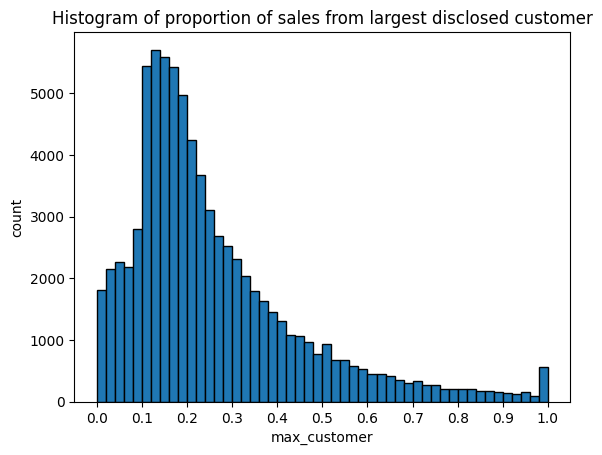

In [31]:
# 进行筛选，保留 max_customer 列在 0 到 1 之间的行
filtered_data = biggest_customers[(biggest_customers['max_customer'] > 0) & (biggest_customers['max_customer'] <= 1)]

# 设置直方图的 bin 宽度
binwidth = 0.02

# 绘制直方图
plt.hist(filtered_data['max_customer'], bins=np.arange(0, 1+binwidth, binwidth), edgecolor='black')

plt.xticks(np.arange(0, 1.1, 0.1))

plt.title('Histogram of proportion of sales from largest disclosed customer')
plt.xlabel('max_customer')
plt.ylabel('count')

plt.show()


上图展示了最大客户销售占比的情况。
+ 有些情况下最大客户销售额占比超过100％；其中许多情况可能是由于数据录入错误。
+ 有数百个公司年份的收入仅来自一个客户。
+ 在销售额的10％处存在一个跳跃，这很可能是由于法律要求的规定，当公司的某个客户占据其总销售额的10%以上时，必须披露与该客户相关的重要信息。但许多公司即使最大客户销售额占比低于10％，也披露了重要客户的信息。

Li et al. (2018) 仅包括至少披露了一个客户（无论是否被识别），且该客户的销售额占比不低于10%的公司年度数据。我们构建了一个数据集（prin_custs）来识别这些公司。

In [32]:
prin_custs = disclosure_raw.merge(sales, how = 'inner', on=['gvkey', 'datadate'])

prin_custs = prin_custs[prin_custs['salecs'].notna()]

prin_custs = (prin_custs[prin_custs['sale'] > 0]
              .assign(prin_cust = lambda x:x['salecs'] / x['sale'])
              .groupby(['gvkey', 'datadate'])['prin_cust']
              .agg(prin_cust = lambda x: x.max(skipna=True))
              .reset_index())

prin_custs['has_prin_cust'] = prin_custs['prin_cust'] >= 0.1


接下来将数据限制在Li et al. (2018) 样本中的公司（GVKEYs）上，R语言farr包中的 llz_2018 数据集包含了这些公司。并计算Li et al. (2018)中使用的两个披露选择指标：
+ 一个指标衡量未披露身份的重要客户比例
+ 另一个将该比例按销售额加权。

In [34]:
llz_2018 = pd.read_csv('/Users/ravenyang/Desktop/code/llz_2018.csv')

llz_2018['gvkey'] = llz_2018['gvkey'].astype(str)
llz_2018['gvkey'] = llz_2018['gvkey'].str.pad(width=6, side='left', fillchar='0')


In [35]:
tmp = (disclosure_raw
       .merge(sales, how = 'inner', on = ["gvkey", "datadate"])
       .merge(llz_2018, how = 'inner', on = "gvkey"))

grouped_df = tmp.groupby(["gvkey", "datadate"])

disclosure = pd.DataFrame(columns=["gvkey", "datadate", "ratio", "ratio_sale"])
i = 0

for group_key, group_data in grouped_df:
    disclosure.loc[i] = ([group_key[0], 
                          group_key[1], 
                          1 - group_data['disclosed'].mean(), 
                          ((~group_data['disclosed']) * group_data['salecs']).sum() / group_data['salecs'].sum()])
    i = i + 1


disclosure['year'] = pd.to_datetime(disclosure["datadate"]).dt.year


num = 500
num = 1000
num = 1500
num = 2000
num = 2500
num = 3000
num = 3500
num = 4000
num = 4500
num = 5000
num = 5500
num = 6000
num = 6500
num = 7000
num = 7500
num = 8000
num = 8500
num = 9000
num = 9500
num = 10000
num = 10500
num = 11000
num = 11500
num = 12000
num = 12500
num = 13000
num = 13500
num = 14000
num = 14500
num = 15000
num = 15500
num = 16000
num = 16500
num = 17000
num = 17500
num = 18000
num = 18500
num = 19000
num = 19500
num = 20000
num = 20500
num = 21000
num = 21500
num = 22000
num = 22500
num = 23000
num = 23500
num = 24000
num = 24500
num = 25000
num = 25500
num = 26000
num = 26500
num = 27000
num = 27500
num = 28000
num = 28500
num = 29000
num = 29500
num = 30000
num = 30500
num = 31000
num = 31500
num = 32000
num = 32500
num = 33000
num = 33500
num = 34000
num = 34500
num = 35000
num = 35500
num = 36000
num = 36500
num = 37000
num = 37500
num = 38000
num = 38500
num = 39000
num = 39500
num = 40000
num = 40500
num = 41000
num = 41500
num = 42000
num = 42500


下表提供了两种披露选择指标的汇总统计信息。这些与Li et al. (2018)披露的信息相当相似。

In [36]:
# 将dataframe转换为长格式
melted_df = disclosure.melt(id_vars=['gvkey', 'datadate', 'year'], var_name='measure')

# 使用 groupby 和 agg 进行汇总统计
summary_stats = melted_df.groupby('measure').agg(
    mean=('value', 'mean'),
    median=('value', 'median'),
    sd=('value', 'std')
).reset_index()

summary_stats

,measure,mean,median,sd
0,ratio,0.458646,0.333333,0.449422
1,ratio_sale,0.464411,0.337500,0.463885


# 21.2.2 IDD采纳情况数据

接下来使用的数据集是 idd_periods，是R语言 farr 包自带的数据集，源自 Klasa et al. (2018) 报告的数据，并在 Li et al. (2018)的研究中再现。

idd_dates 表示"不可避免披露原则"(Inevitable Disclosure Doctrine, IDD)的采纳或拒绝日期。

In [37]:
idd_dates = pd.read_csv('/Users/ravenyang/Desktop/code/idd_dates.csv')

idd_dates

,state,idd_date,idd_type
0,AR,1997-03-18,Adopt
1,CT,1996-02-28,Adopt
2,DE,1964-05-05,Adopt
3,FL,1960-07-11,Adopt
4,FL,2001-05-21,Reject
5,GA,1998-06-29,Adopt
6,IL,1989-02-09,Adopt
7,IN,1995-07-12,Adopt
8,IA,1997-03-18,Adopt
9,KS,2006-02-02,Adopt


idd_periods 表将一个样本期间（使用 min_date 和 max_date 定义）按州分为三种类型：采纳前(pre-adoption)、采纳后(post-adoption)和拒绝后(post-rejection)。

In [38]:
idd_periods = pd.read_csv('/Users/ravenyang/Desktop/code/idd_periods.csv')

idd_periods

,state,period_type,start_date,end_date
0,AK,Pre-adoption,1994-01-01,2010-12-31
1,AL,Pre-adoption,1994-01-01,2010-12-31
2,AR,Pre-adoption,1994-01-01,1997-03-18
3,AR,Post-adoption,1997-03-18,2010-12-31
4,AZ,Pre-adoption,1994-01-01,2010-12-31
...,...,...,...,...
60,WA,Pre-adoption,1994-01-01,1997-12-30
61,WA,Post-adoption,1997-12-30,2010-12-31
62,WI,Pre-adoption,1994-01-01,2010-12-31
63,WV,Pre-adoption,1994-01-01,2010-12-31


# 21.2.3 总部所在州的数据

数据的最后一部分是 state_hq，它包含了 Li et al. (2018)使用的公司总部位置信息。这个数据由R语言的 farr 包提供，源自 Bill McDonald 提供的数据。state_hq 表报告了每个 CIK（cik）和总部所在州（ba_state）的组合适用的 SEC 文件提交的日期范围。

In [39]:
state_hq = pd.read_csv('/Users/ravenyang/Desktop/code/state_hq.csv')

state_hq['cik'] = state_hq['cik'].astype(str)

state_hq['cik'] = state_hq['cik'].str.pad(width=10, side='left', fillchar='0')
state_hq

,cik,ba_state,min_date,max_date
0,0000066382,MI,1994-01-04,2018-10-10
1,0000070415,NY,1994-01-04,2007-03-14
2,0000084129,PA,1994-01-05,2018-10-04
3,0000832922,OH,1994-01-05,2001-01-09
4,0000909832,CA,1994-01-05,1996-12-20
...,...,...,...,...
53128,0001751783,NY,2018-12-24,2018-12-24
53129,0001743886,IL,2018-12-26,2018-12-26
53130,0000726293,CA,2018-08-15,2018-12-27
53131,0001438901,NV,2018-11-09,2018-12-27


为了使用这些数据，需要将 CIK（美国证券交易委员会识别码）与 GVKEYs（Compustat 数据库中的唯一公司标识符）进行连接。

In [40]:
ciks = names_seg[names_seg['cik'].notna()]

state_hq_linked 提供了每个公司年度（即 gvkey 和 datadate 的组合）适用的总部所在州信息。

In [41]:
state_hq_linked = (state_hq
                   .merge(ciks, how = 'inner', on = 'cik')
                   .merge(disclosure, how = 'inner', on = 'gvkey')
                   .query('min_date < datadate < max_date')[['gvkey', 'datadate', 'ba_state']]
                   .rename(columns={'ba_state':'state'}))
state_hq_linked

,gvkey,datadate,state
0,007401,1994-05-31,MI
1,007401,1995-05-31,MI
2,007401,1996-05-31,MI
3,007401,1997-05-31,MI
4,007401,1998-05-31,MI
...,...,...,...
54153,012621,2010-12-31,NC
54161,028916,2010-12-31,NY
56062,065344,2008-12-31,AZ
56063,065344,2009-12-31,AZ


# 21.2.4 回归分析

将所有上述部分整合在一起。与Li et al. (2018)类似，我们删除了“post-rejection”观察值，并对因变量进行了对数转换。

In [101]:
reg_data = disclosure.merge(prin_custs, how = 'inner', on = ["gvkey", "datadate"])
reg_data = (reg_data[reg_data['has_prin_cust']]
            .merge(state_hq_linked, how = 'inner', on = ["gvkey", "datadate"])
            .merge(idd_periods, how = 'inner', on = 'state')
            .query('start_date <= datadate <= end_date'))
reg_data = (reg_data[reg_data['period_type'] != "Post-rejection"]
            .assign(post = lambda x: x['period_type'] == "Post-adoption", 
                    ln_ratio = lambda x: np.log(1 + x['ratio']), 
                    ln_ratio_sale = lambda x: np.log(1 + x['ratio_sale']))
            .drop(['start_date', 'end_date'], axis=1))

reg_data['period_type'].value_counts()



period_type
Post-adoption    15836
Pre-adoption     12921
Name: count, dtype: int64

为了分析简单，在下面的回归中没有包含控制变量（除了公司和年份固定效应）。

在具有公司和年份固定效应的典型回归分析中，省略控制变量通常不会对系数估计产生实质性影响。

In [103]:
data = reg_data.set_index(["gvkey", "year"])
exog = data['post']
model_ratio = PanelOLS(data['ln_ratio'], exog, entity_effects=True, time_effects=True, drop_absorbed=True)


model_ratio_sale = PanelOLS(data['ln_ratio_sale'], exog, entity_effects=True, time_effects=True, drop_absorbed=True)

result_ratio = model_ratio.fit(cov_type='unadjusted')
result_ratio_sale = model_ratio_sale.fit(cov_type='unadjusted')


fms = [[result_ratio.params.values[0], 
        result_ratio.pvalues.values[0], 
        result_ratio.std_errors.values[0]], 
       [result_ratio_sale.params.values[0], 
        result_ratio_sale.pvalues.values[0], 
        result_ratio_sale.std_errors.values[0]]]

fms = pd.DataFrame(fms, columns=['params', 'pvalues', 'std_errors'], index=['ln_ratio', 'ln_ratio_sale'])


,params,pvalues,std_errors
ln_ratio,0.015840,0.043748,0.007855
ln_ratio_sale,0.019594,0.016054,0.008138


然后再次进行分析，但集中在 之前未采纳、但后续采纳了IDD的公司上。

In [104]:
# 选取不同的 gvkey 和 post 组合，并筛选出具有多个观测值的组
switchers = (reg_data[['gvkey', 'post']]
             .drop_duplicates().groupby('gvkey')
             .filter(lambda x: len(x) > 1)
             .drop_duplicates()['gvkey'])


# 根据 switchers 中的 gvkey 对 reg_data 进行筛选
reg_data_switchers = reg_data.merge(switchers, on='gvkey', how='inner').drop_duplicates()


data = reg_data_switchers.set_index(["gvkey", "year"])
exog = data['post']
model_ratio_switchers = PanelOLS(data['ln_ratio'], exog, entity_effects=True, time_effects=True, drop_absorbed=True)


model_ratio_sale_switchers = PanelOLS(data['ln_ratio_sale'], exog, entity_effects=True, time_effects=True, drop_absorbed=True)

result_ratio_switchers = model_ratio_switchers.fit(cov_type='unadjusted')
result_ratio_sale_switchers = model_ratio_sale_switchers.fit(cov_type='unadjusted')


fms_switchers = [[result_ratio_switchers.params.values[0],
                  result_ratio_switchers.pvalues.values[0],
                  result_ratio_switchers.std_errors.values[0]],
                 [result_ratio_sale_switchers.params.values[0],
                  result_ratio_sale_switchers.pvalues.values[0],
                  result_ratio_sale_switchers.std_errors.values[0]]]

fms_switchers = pd.DataFrame(fms_switchers, columns=['params', 'pvalues', 'std_errors'], 
                             index=['ln_ratio_switchers', 'ln_ratio_sale_switchers'])



fms = pd.concat([fms, fms_switchers], axis = 0)
fms


,params,pvalues,std_errors
ln_ratio,0.015840,0.043748,0.007855
ln_ratio_sale,0.019594,0.016054,0.008138
ln_ratio_switchers,0.014172,0.122053,0.009163
ln_ratio_sale_switchers,0.015243,0.112120,0.009592


接下来研究采纳IDD政策对随后每一年披露行为的影响。

首先创建一个名为factor_t()的函数，该函数接受一个数字向量，并将它们作为因子返回。

In [52]:
def factor_t(t):
    # Convert to categorical
    ref = -1
    t = pd.Categorical(t, categories=[ref] + sorted(set(t) - {ref}), ordered=True)

    # Format levels
    levels = [f" + {level}" if level >= 0 else level for level in t.categories]
    levels = [f" - {abs(level)}" if (isinstance(level, int) or isinstance(level, float)) else level for level in levels]
    t = t.rename_categories(levels)
    return t


接下来创建一个函数，将一个年份差异值的向量转换为因子，将(-5,+5)范围外的值适当地合并为-5和+5，并以一种便于回归输出的方式标记结果。

如果一个公司从未采用过IDD，其 t 值将缺失，将这些年份的值设置为 $-\infty$。

In [56]:
def year_diff(t):
    t = [-5 if x < -5 
         else 5 if x > 5 
         else -np.inf if np.isnan(x) 
         else x 
         for x in t]
    return factor_t(t)


构建一个数据集（switch_years），包含每个 GVKEY 首次采用 IDD 的年份的数据。

In [57]:
switch_years = (reg_data
                .groupby('gvkey')
                .apply(lambda x: x.sort_values(by='datadate'))
                .reset_index(drop=True))

switch_years['lag_period_type'] = switch_years.groupby('gvkey')['period_type'].transform('shift')

switch_years = (switch_years
                .query('period_type == "Post-adoption" and lag_period_type == "Pre-adoption"')
                .groupby('gvkey')
                .agg(adoption_year=('year', 'min'))
                .reset_index())


switch_years.head()

,gvkey,adoption_year
0,001082,1999
1,001234,1998
2,001244,1998
3,001281,2000
4,001308,2001


接下来通过合并采用年份的数据来构建回归分析的数据集（reg_data_t），然后使用上面创建的year_diff()函数计算t。

In [58]:
reg_data_t = reg_data.merge(switch_years, how = 'left', on = 'gvkey')
reg_data_t['t'] = year_diff(reg_data_t['year'] - reg_data_t['adoption_year'])


reg_data_t.head()


,gvkey,datadate,ratio,ratio_sale,year,prin_cust,has_prin_cust,state,period_type,post,ln_ratio,ln_ratio_sale,adoption_year,t
0,001004,1999-05-31,1.000000,1.000000,1999,0.147162,True,IL,Post-adoption,True,0.693147,0.693147,NaN,- inf
1,001004,2000-05-31,1.000000,1.000000,2000,0.111292,True,IL,Post-adoption,True,0.693147,0.693147,NaN,- inf
2,001013,2002-10-31,0.000000,0.000000,2002,0.106000,True,MN,Post-adoption,True,0.000000,0.000000,NaN,- inf
3,001013,2003-10-31,1.000000,1.000000,2003,0.256999,True,MN,Post-adoption,True,0.693147,0.693147,NaN,- inf
4,001013,2004-10-31,0.666667,0.712743,2004,0.171000,True,MN,Post-adoption,True,0.510826,0.538096,NaN,- inf


针对两个披露度量指标分别进行两次回归。其中，回归3和4剔除了从未采用过IDD的公司。

In [230]:
# Define the models
data = reg_data_t.set_index(["gvkey", "year"])
exog = data['t']
model1 = PanelOLS(data['ln_ratio'], exog, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False)
model2 = PanelOLS(data['ln_ratio_sale'], exog, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False)


data3_4 = reg_data_t[~reg_data_t['t'].str.contains('inf')]
data = data3_4.set_index(["gvkey", "year"])
exog = data['t']
model3 = PanelOLS(data['ln_ratio'], exog, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False)
model4 = PanelOLS(data['ln_ratio_sale'], exog, entity_effects=True, time_effects=True, drop_absorbed=True, check_rank=False)


# Fit the models
result1 = model1.fit(cov_type='unadjusted')
result2 = model2.fit(cov_type='unadjusted')
result3 = model3.fit(cov_type='unadjusted')
result4 = model4.fit(cov_type='unadjusted')

pd.DataFrame({'(1)_params': result1.params.values.tolist(), 
              '(1)_pvalues': result1.pvalues.values.tolist(),
              '(2)_params': result2.params.values.tolist(), 
              '(2)_pvalues': result2.pvalues.values.tolist(),
              '(3)_params': result3.params.values.tolist(), 
              '(3)_pvalues': result3.pvalues.values.tolist(),
              '(4)_params': result4.params.values.tolist(), 
              '(4)_pvalues': result4.pvalues.values.tolist()},
             index = ['t-5', 't-4', 't-3', 't-2', 't+0', 't+1', 't+2', 't+3', 't+4', 't+5'])

,(1)_params,(1)_pvalues,(2)_params,(2)_pvalues,(3)_params,(3)_pvalues,(4)_params,(4)_pvalues
t-5,-0.004342,0.821352,-0.008213,0.680124,-0.017416,0.515898,-0.012319,0.659362
t-4,-0.017121,0.438777,-0.014881,0.515934,-0.026133,0.292192,-0.020153,0.435892
t-3,-0.029910,0.131556,-0.023221,0.258421,-0.030851,0.149224,-0.023658,0.288719
t-2,-0.008381,0.632071,-0.005718,0.752501,-0.014344,0.438601,-0.009616,0.618438
t+0,-0.000869,0.953300,0.009345,0.543225,0.006873,0.668331,0.014773,0.377095
t+1,0.008605,0.588764,0.015824,0.337204,0.020618,0.259914,0.023993,0.208603
t+2,-0.007565,0.662364,-0.000076,0.996613,0.009370,0.660209,0.009197,0.678940
t+3,0.022750,0.219104,0.023482,0.220770,0.038407,0.118141,0.027548,0.282310
t+4,0.028041,0.148487,0.039030,0.052214,0.041294,0.131940,0.039131,0.170896
t+5,0.043556,0.002891,0.056595,0.000187,0.046298,0.149898,0.039469,0.239021


下一步，创建一个函数来绘制随时间变化的估计系数。该函数首先将每个时期的系数排列为一个数据框，并将系数标签（例如，t+1）转换为值（即，1）。在制作图表时，我们还添加了参考期（t-1），其系数值根据定义为0，并为系数添加了95%置信区间。

In [209]:
fm1 = pd.DataFrame(result1.summary.tables[1])
fm2 = pd.DataFrame(result2.summary.tables[1])
fm3 = pd.DataFrame(result3.summary.tables[1])
fm4 = pd.DataFrame(result4.summary.tables[1])


def plot_coefs(fm, ci=0.95):
    fm.columns = fm.iloc[0]
    fm = fm.iloc[1:]

    fm.set_index(fm.columns[0], inplace=True)

    coefs = pd.DataFrame({'t': fm.index.astype(str), 'value': fm.iloc[:, 0], 'se': fm.iloc[:, 1]})
    coefs['t'] = [re.sub(r't\. ([\+\-]? \d+\.0)', r'\1', s) for s in coefs['t']]
    coefs['t'] = [s.replace(' ', '') for s in coefs['t']]
    coefs['t'] = [int(float(s)) for s in coefs['t']]

    coefs = coefs[coefs['t'] != -float('inf')]

    for i in range(len(coefs)):
        coefs['value'][i] = coefs['value'][i].data
        coefs['se'][i] = coefs['se'][i].data

    coefs['value'] = coefs['value'].astype(float)
    coefs['se'] = coefs['se'].astype(float)


    new_row = {'t' : -1, 'value' : 0, 'se' : 0}
    new_row_df = pd.DataFrame([new_row])

    coefs = pd.concat([new_row_df, coefs], axis=0)

    ci = 0.95
    mult = norm.ppf(1 - (1 - ci) / 2)
    coefs['mean'] = coefs['value']
    coefs['top'] = coefs['value'] + mult * coefs['se']
    coefs['bot'] = coefs['value'] - mult * coefs['se']

    coefs = coefs.sort_values(by='t', ascending=True)

    plt.errorbar(coefs['t'], coefs['mean'], yerr=mult * coefs['se'], fmt='o', label='Coefficient')
    plt.plot(coefs['t'], coefs['mean'], linestyle='-', marker='o')

    plt.xlabel('t')
    plt.ylabel('mean')
    plt.xticks(np.arange(min(coefs['t']), max(coefs['t'])+1, 1))
    plt.grid(True)
    plt.legend()
    plt.show()


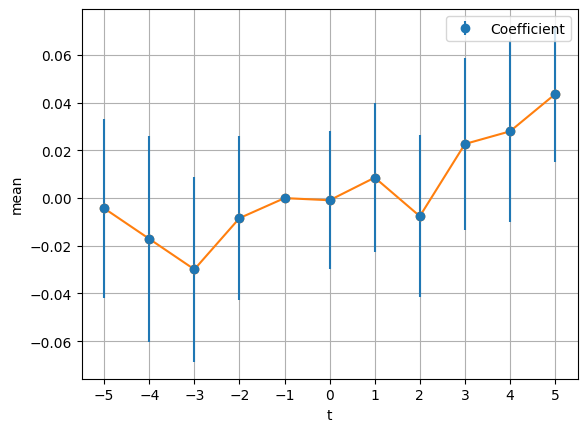

In [210]:
plot_coefs(fm1)